# CNN Model

This code is an adaptation of the CNN model provided by Professor Jorge Henriques in the course slides, the CNN model developed for another course (available at https://github.com/leosousa200/RetinopathyAlgorithm), a guide to multi-input CNN provided by Keras (available at https://keras.io/guides/functional_api/) and a CNN model available on Kaggle (at https://www.kaggle.com/code/vishwasgpai/guide-for-creating-cnn-model-using-csv-file/notebook).

### Imports

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, Concatenate

from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

### Data Preprocessing and Organization

In [ ]:
numeric = pd.read_csv("COVID_numerics.csv").values
images  = pd.read_csv("COVID_IMG.csv",header=None).values # avoids ignoring first line!

X_num = numeric[:,0:8] # 8 columns (GENDER,AGE,MARITAL STATUS,VACINATION,RESPIRATION CLASS,HEART RATE,SYSTOLIC BLOOD PRESSURE,TEMPERATURE)
T = numeric[:,8] # Target
X_img = images[:,:] # each line represents a 21x21 image

# RULE: IF breathing difficulty >= moderate AND Temperature > 37.8 THEN Stay at hospital (T=1)
T[(numeric[:, 4]>=2) & (numeric[:, 7]>=37.8)] = 1

t0 = np.sum(T==0)
t1 = np.sum(T==1)
print(f"Number of cases with T=0: {t0}")
print(f"Number of cases with T=1: {t1}")

Number of cases with T=0: 359
Number of cases with T=1: 241


### Reshape Image Data (21x21)

In [29]:
X_img = X_img.reshape(X_img.shape[0],21,21,1) # resize images into 21x21x1

### Train-Test Split

In [30]:
X_img_train, X_img_test, X_num_train, X_num_test, T_train, T_test = train_test_split(X_img, X_num, T, test_size=0.3, random_state=42)

### Model

In [31]:
numeric_input = Input(shape=(8,))
image_input = Input(shape=(21,21,1))

# CNN Path Only for the Images
x_img = Conv2D(64, (3, 3), activation='relu')(image_input)
x_img = MaxPooling2D(pool_size=(2, 2))(x_img)
x_img = Conv2D(32, (3, 3), activation='relu')(x_img)
x_img = MaxPooling2D(pool_size=(2, 2))(x_img)
x_img = Flatten()(x_img)

# MLP Path Only for Numerical Data
x_num = Dense(64, activation='relu')(numeric_input)

# Concatenate Outputs
concatenated = Concatenate()([x_img, x_num])

# Final Output Dense Layer
output = Dense(1,activation='sigmoid')(concatenated) # this is a binary classification problem, so we can use the Sigmoid activation function

model = Model(inputs=[image_input,numeric_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 21, 21, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 19, 19,    │        640 │ input_layer_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 9, 9, 64)  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 7, 7, 32)  │     18,464 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 3, 3, 32)  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 288)       │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │        576 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 352)       │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        353 │ concatenate_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [32]:
history = model.fit([X_img_train, X_num_train], T_train, epochs=12, batch_size=64)
print("Loss: ", history.history['loss'])

train = model.predict([X_img_train, X_num_train]).round()

Epoch 1/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5985 - loss: 1.3631
Epoch 2/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6467 - loss: 0.7785
Epoch 3/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6154 - loss: 0.7367
Epoch 4/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7023 - loss: 0.6408 
Epoch 5/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7414 - loss: 0.5439
Epoch 6/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7620 - loss: 0.4883
Epoch 7/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7701 - loss: 0.4864
Epoch 8/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7752 - loss: 0.4834
Epoch 9/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8200 - loss: 0.4178
Epoch 10/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7811 - loss: 0.4652
Epoch 11/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8126 - loss: 0.4271
Epoch 12/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8254 - loss: 0.4219
L

### Test Model

In [33]:
Ytest = model.predict([X_img_test, X_num_test]).round()
scores = model.evaluate([X_img_test, X_num_test], T_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Baseline Error: 20.00%


### Evaluate Model

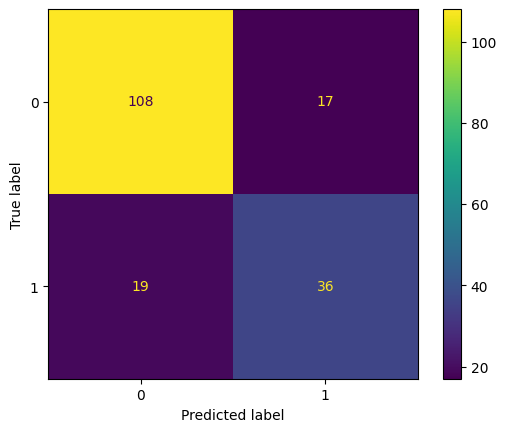

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86       125
         1.0       0.68      0.65      0.67        55

    accuracy                           0.80       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.80      0.80      0.80       180



In [34]:
cm = confusion_matrix(T_test, Ytest)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(classification_report(T_test,Ytest))